In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence
from torch.cuda.amp import autocast, GradScaler  # Mixed precision

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix
import joblib
import os
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

print(f"CUDA: {torch.cuda.is_available()}")

CUDA: True


In [2]:
class SequentialCourseDataset(Dataset):
    def __init__(self, X, mask, y=None):
        self.X = torch.FloatTensor(X)
        self.mask = torch.BoolTensor(mask)
        self.lengths = mask.sum(axis=1).astype(np.int32)
        self.y = torch.LongTensor(y) if y is not None else None
    
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        return {
            'X': self.X[idx],
            'length': torch.tensor(self.lengths[idx]),
            'y': self.y[idx] if self.y is not None else None
        }

In [3]:
# ĐƯỜNG DẪN CỦA BẠN
TRAIN_PATH = r"/home/check/DATA/university/yr3, hk1/DS317 - Khai phá dữ liệu trong doanh nghiệp/3 Do an cuoi ky/data/course_train.npz"
TEST_PATH  = r"/home/check/DATA/university/yr3, hk1/DS317 - Khai phá dữ liệu trong doanh nghiệp/3 Do an cuoi ky/data/course_test.npz"

# Load
data_train = np.load(TRAIN_PATH, allow_pickle=True)
X_full = data_train['X']
mask_full = data_train['mask']
y_full = (data_train['y'] - 1).astype(np.int64)

data_test = np.load(TEST_PATH, allow_pickle=True)
X_test = data_test['X']
mask_test = data_test['mask']
y_test = (data_test['y'] - 1).astype(np.int64)

# Chia val 10%
from sklearn.model_selection import train_test_split
X_train, X_val, mask_train, mask_val, y_train, y_val = train_test_split(
    X_full, mask_full, y_full, test_size=0.1, random_state=42, stratify=y_full
)

# Scaling
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train.reshape(-1, 38)).reshape(X_train.shape)
X_val   = scaler.transform(X_val.reshape(-1, 38)).reshape(X_val.shape)
X_test  = scaler.transform(X_test.reshape(-1, 38)).reshape(X_test.shape)

print("Data ready!")

Data ready!


In [4]:
from sklearn.model_selection import KFold

kfold = KFold(n_splits=3, shuffle=True, random_state=42)
cv_macro_f1 = []

for fold, (tr_idx, va_idx) in enumerate(kfold.split(X_full)):
    print(f"\n=== FOLD {fold+1}/3 ===")
    # Lấy data fold
    X_tr = X_full[tr_idx]
    X_va = X_full[va_idx]
    mask_tr = mask_full[tr_idx]
    mask_va = mask_full[va_idx]
    y_tr = y_full[tr_idx]
    y_va = y_full[va_idx]
    
    # Scaling trên fold train
    scaler_cv = StandardScaler()
    X_tr = scaler_cv.fit_transform(X_tr.reshape(-1, 38)).reshape(X_tr.shape)
    X_va = scaler_cv.transform(X_va.reshape(-1, 38)).reshape(X_va.shape)


=== FOLD 1/3 ===

=== FOLD 2/3 ===

=== FOLD 3/3 ===


In [5]:
batch_size = 256  # GRU nhẹ nên 512 ok
train_loader = DataLoader(SequentialCourseDataset(X_train, mask_train, y_train), batch_size=batch_size, shuffle=True, num_workers=8, pin_memory=True)
val_loader   = DataLoader(SequentialCourseDataset(X_val,   mask_val,   y_val),   batch_size=batch_size, shuffle=False, num_workers=8, pin_memory=True)
test_loader  = DataLoader(SequentialCourseDataset(X_test,  mask_test,  y_test),  batch_size=batch_size, shuffle=False, num_workers=8, pin_memory=True)

In [6]:
class Attention(nn.Module):
    def __init__(self, hidden_dim):
        super().__init__()
        self.W = nn.Linear(hidden_dim * 2, hidden_dim * 2, bias=False)
        self.U = nn.Linear(hidden_dim * 2, hidden_dim * 2, bias=False)
        self.v = nn.Linear(hidden_dim * 2, 1, bias=False)
    
    def forward(self, hidden, encoder_outputs):
        # hidden: (batch, hidden*2)
        # encoder_outputs: (batch, seq_len, hidden*2)
        hidden = hidden.unsqueeze(1)  # (batch, 1, hidden*2)
        energy = torch.tanh(self.W(hidden) + self.U(encoder_outputs))  # broadcast
        attention = self.v(energy).squeeze(2)  # (batch, seq_len)
        return torch.softmax(attention, dim=1)

class GRUAttention(nn.Module):
    def __init__(self, input_dim=38, hidden_dim=256, num_layers=3, dropout=0.5, num_classes=5):
        super().__init__()
        self.gru = nn.GRU(input_dim, hidden_dim, num_layers, bidirectional=True, batch_first=True, dropout=dropout if num_layers > 1 else 0.0)
        self.attention = Attention(hidden_dim)
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(hidden_dim * 2, num_classes)
    
    def forward(self, x, lengths):
        packed = pack_padded_sequence(x, lengths.cpu(), batch_first=True, enforce_sorted=False)
        gru_out, hn = self.gru(packed)
        gru_out, _ = pad_packed_sequence(gru_out, batch_first=True)
        
        forward_h = hn[-2]
        backward_h = hn[-1]
        context = torch.cat([forward_h, backward_h], dim=1)
        
        attn_weights = self.attention(context, gru_out)
        context_vector = torch.bmm(attn_weights.unsqueeze(1), gru_out).squeeze(1)
        
        out = self.dropout(context_vector)
        return self.fc(out)

In [7]:
class FocalLoss(nn.Module):
    def __init__(self, alpha=None, gamma=2.0, reduction='mean'):
        super().__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.reduction = reduction

    def forward(self, inputs, targets):
        ce_loss = nn.CrossEntropyLoss(weight=self.alpha, reduction='none')(inputs, targets)
        pt = torch.exp(-ce_loss)
        focal_loss = (1 - pt) ** self.gamma * ce_loss
        if self.reduction == 'mean':
            return focal_loss.mean()
        elif self.reduction == 'sum':
            return focal_loss.sum()
        else:
            return focal_loss

In [8]:
os.makedirs('models', exist_ok=True)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = GRUAttention(
    input_dim=38,
    hidden_dim=256,
    num_layers=3,
    dropout=0.3,
    num_classes=5
).to(device)

if torch.cuda.device_count() > 1:
    model = nn.DataParallel(model)

# Class weights
class_counts = np.bincount(y_train)
class_weights = 1.0 / (class_counts ** 0.8).astype(float)
class_weights = class_weights / class_weights.sum() * 5
class_weights = torch.FloatTensor(class_weights).to(device)

criterion = nn.CrossEntropyLoss(weight=class_weights)
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=4)
scaler_amp = GradScaler()  # AMP

best_f1 = 0
patience_count = 0

for epoch in range(10):
    model.train()
    train_loss = 0
    for batch in train_loader:
        optimizer.zero_grad(set_to_none=True)
        
        with autocast():
            logits = model(batch['X'].to(device), batch['length'].to(device))
            loss = criterion(logits, batch['y'].to(device))
        
        scaler_amp.scale(loss).backward()
        scaler_amp.unscale_(optimizer)
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        scaler_amp.step(optimizer)
        scaler_amp.update()
        
        train_loss += loss.item()
    
    # Validation (tắt AMP cho val)
    model.eval()
    val_preds, val_trues = [], []
    val_loss = 0
    with torch.no_grad():
        for batch in val_loader:
            logits = model(batch['X'].to(device), batch['length'].to(device))
            loss = criterion(logits, batch['y'].to(device))
            val_loss += loss.item()
            val_preds.extend(torch.argmax(logits,1).cpu().numpy())
            val_trues.extend(batch['y'].numpy())
    
    val_f1 = f1_score(val_trues, val_preds, average='macro')
    print(f"Epoch {epoch+1} | Val Macro F1: {val_f1:.4f}")
    
    scheduler.step(val_loss / len(val_loader))
    
    if val_f1 > best_f1:
        best_f1 = val_f1
        torch.save(model.state_dict(), 'models/best_gru_attention.pth')
        joblib.dump(scaler, 'models/gru_attention_scaler.pkl')
        patience_count = 0
        print("  → Saved best!")
    else:
        patience_count += 1
        if patience_count >= 8:
            print("Early stopping")
            break

/tmp/ipykernel_122296/3967550927.py:24: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler_amp = GradScaler()  # AMP
/tmp/ipykernel_122296/3967550927.py:35: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 1 | Val Macro F1: 0.7091
  → Saved best!


/tmp/ipykernel_122296/3967550927.py:35: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 2 | Val Macro F1: 0.8568
  → Saved best!


/tmp/ipykernel_122296/3967550927.py:35: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 3 | Val Macro F1: 0.9327
  → Saved best!


/tmp/ipykernel_122296/3967550927.py:35: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 4 | Val Macro F1: 0.9459
  → Saved best!


/tmp/ipykernel_122296/3967550927.py:35: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 5 | Val Macro F1: 0.9588
  → Saved best!


/tmp/ipykernel_122296/3967550927.py:35: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 6 | Val Macro F1: 0.9605
  → Saved best!


/tmp/ipykernel_122296/3967550927.py:35: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 7 | Val Macro F1: 0.9639
  → Saved best!


/tmp/ipykernel_122296/3967550927.py:35: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 8 | Val Macro F1: 0.9699
  → Saved best!


/tmp/ipykernel_122296/3967550927.py:35: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 9 | Val Macro F1: 0.9660


/tmp/ipykernel_122296/3967550927.py:35: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 10 | Val Macro F1: 0.9699
  → Saved best!


TEST - Accuracy: 0.6391 | Macro F1: 0.5326


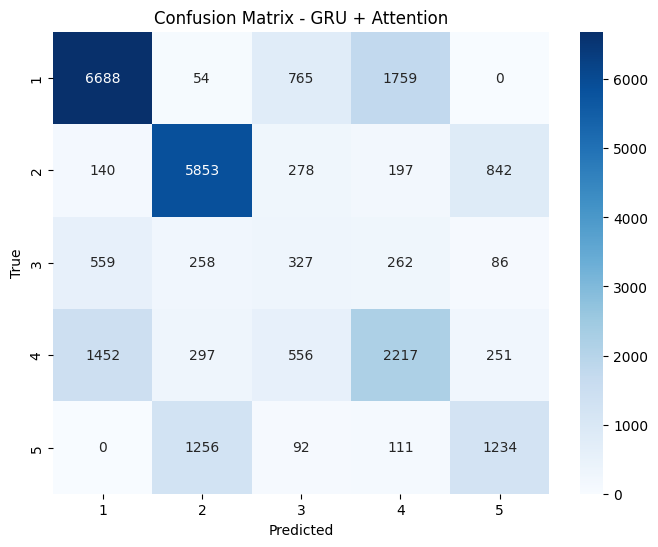

In [11]:
model.load_state_dict(torch.load('models/best_gru_attention.pth'))
model.eval()

preds = []
with torch.no_grad():
    for batch in test_loader:
        logits = model(batch['X'].to(device), batch['length'].to(device))
        preds.extend(torch.argmax(logits,1).cpu().numpy())

acc = accuracy_score(y_test, preds)
macro_f1 = f1_score(y_test, preds, average='macro')

print(f"TEST - Accuracy: {acc:.4f} | Macro F1: {macro_f1:.4f}")

cm = confusion_matrix(y_test, preds)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=[1,2,3,4,5], yticklabels=[1,2,3,4,5])
plt.title('Confusion Matrix - GRU + Attention')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()